<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>main()</code></a></span></li><li><span><a href="#post-main()" data-toc-modified-id="post-main()-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>post-<code>main()</code></a></span></li><li><span><a href="#ML-Stuff" data-toc-modified-id="ML-Stuff-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ML Stuff</a></span></li><li><span><a href="#References-&amp;-Further-Reading:" data-toc-modified-id="References-&amp;-Further-Reading:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References &amp; Further Reading:</a></span></li></ul></div>

In [53]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# !pip install statsmodels
import statsmodels.api as sm

import time
from IPython.display import clear_output

In [59]:
def getTargets():
    """Retrives the target matrix from "targets.csv". 
    
    The mice were scored on a test and grouped into 3 categories: GT, IR, and ST. 
    GT was the worst and ST was the best. These groups have been integer encoded.

    Returns:
        Y (np.ndarray): Phenotype values to be predicted by ML model. 
        names (np.ndarray): The names of the rats.
    """
    df = pd.read_csv("targets.csv")

    # Check if targets.csv contains the same IDs as the feature matrix
    targetRatIDs = df.loc[(df["Vendor"] == "Charles River")][["RatID", "Phenotype"]].values
    miceIDs = np.array(data.columns)[1:].astype(int)
    assert len((a:=set(targetRatIDs[:, 0])).intersection((b:=set(miceIDs)))) == 1780

    # Remove uncommon elements
    for number in a.difference(b):
        targetRatIDs[:, 0] = np.where((targetRatIDs[:, 0] == number), None, targetRatIDs[:, 0])    
    targetRatIDs = pd.DataFrame(targetRatIDs, columns=["RatID", "Phenotype"]).dropna()
    assert targetRatIDs.shape[0] == 1780

    targetRatIDs = targetRatIDs.set_index("RatID").sort_index()
    miceIDs.sort()
    assert np.all(targetRatIDs.index.values == miceIDs.astype(int))

    targetRatIDs = targetRatIDs.astype(str)
    targetRatIDs["Phenotype"].value_counts()

    for i, pt in enumerate(targetRatIDs.Phenotype.values):
        if 'GT' in pt:
            targetRatIDs.Phenotype.iloc[i] = '0'
        if 'IR' in pt:
            targetRatIDs.Phenotype.iloc[i] = '1'
        if 'ST' in pt:
            targetRatIDs.Phenotype.iloc[i] = '2'

    assert len(targetRatIDs.Phenotype.value_counts()) == 3
    
    Y = targetRatIDs.Phenotype.values.astype(int).reshape(-1, 1)
    names = np.array(list(targetRatIDs.index))

    assert X.shape[0] == Y.shape[0]

    return Y, names

In [ ]:
def getCriterion(X, Y, get_coefs=True, test_fn=False) -> np.ndarray:
    """ Get the feature selection criterion, SVM classifier coefficients. 
    
    Args:
        X (np.ndarray, 2D): feature matrix
        Y (np.ndarray, 2D): target matrix
        get_coefs (bool, optional):  Defaults to True.
        test_fn (bool, optional): Checks whether the function works correctly using 
            a randomly generated target matrix, Y_synth. Defaults to False. 
    Returns:
        coefs (np.ndarray, 1D)
    """
    assert X.shape[0] == Y.shape[0], "X and Y have different numbers of samples"
    assert Y.shape[1] == 1, "Y needs to be a column vector"
    
    if test_fn:
        # simulated target matrix, Y
        rng = np.random.RandomState(7)
        Y_synth = rng.randint(0,3, X.shape[0]).reshape(-1,1)
        
    coefs, ps = [], []
    scaler = StandardScaler()
    
    # for each column of X
    for row in X.T:
        x = row.reshape(-1, 1)
        x = scaler.fit_transform(x, Y)
        if get_coefs:
            # Calculate classification coefficients
            model = SGDClassifier(loss='hinge') # SVM classifier
            model.fit(x, Y)
            y_pred = model.predict(x)
            coefs.append(model.coef_[0,0])

        else:
            # Calculate p-values from logit model
            # sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
            sm_model = sm.MNLogit(Y, sm.add_constant(x)).fit(disp=0)
            ps.append(sm_model.pvalues[1])
    
    if get_coefs:
        return (coefs:= np.array(coefs))
    else:
        return (ps:= np.array(ps))

In [54]:
def varAnalysis(X, verbose=False):
    V = np.var(X, axis=0)
    V_avg, V_std = np.mean(V), np.std(V)
    V_max, V_min = np.max(V), np.min(V)
    
    if verbose == True:
        print(f"V_avg: {np.mean(V):.3f}")    
        print(f"V_std: {np.std(V):.3f}")
        print(f"V_max: {np.max(V):.3f}")
        print(f"V_min: {np.min(V):.3f}")
    
    return V_avg, V_std, V_max, V_min

def plotV_info(V_info):
    """[summary]

    Args:
        V_info (dict[np.ndarray]): [description]
    """
    global fig, ax
    figscale, defaultSize = 2, np.array([8, 6])
    fig, ax = plt.subplots(nrows=2, ncols=2 ,figsize=figscale*defaultSize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4, left = 0.1, right = 0.7, bottom = 0.1, top = 0.9) 
    
    ax[0,0].hist(V_info["avg"])
    ax[0,0].set(xlabel="V_avg", ylabel="batches", title="Avg(Var)")
    
    ax[1,0].hist(V_info["std"])
    ax[1,0].set(xlabel="V_std", ylabel="batches", title="Std(Var)")

    ax[0,1].hist(V_info["max"])
    ax[0,1].set(xlabel="V_max", ylabel="batches", title="Max(Var)")

    ax[1,1].hist(V_info["min"])
    ax[1,1].set(xlabel="V_min", ylabel="batches", title="Min(Var)")
    plt.show()

----

## `main()`


In [60]:
def main(plot_vars=False):
    # There are about 220,000 features, so we can loop <= 110 times.
    csvBatchSize = 2000
    maxIteration = 112
    
    V_info = {}
    V_info["avg"] = np.empty(maxIteration + 1) 
    V_info["std"] = np.empty(maxIteration + 1) 
    V_info["max"] = np.empty(maxIteration + 1) 
    V_info["min"] = np.empty(maxIteration + 1) 
    
    global coefs_list
    coefs_list = []
    start_time = time.time()
    
    for csvBatch_idx, csvBatch in enumerate(pd.read_csv("gtTypes_C.csv", chunksize=csvBatchSize)):
        current_time = time.time() - start_time
        minutes = int(current_time / 60)
        seconds = current_time % 60
        print(f"Batch: {csvBatch_idx}.\tTime: {minutes} min, {seconds:.2f} s."
             + f"\tSamples per second: {(csvBatchSize * csvBatch_idx) / current_time:.2f}")

        data = csvBatch
        X = data.values[:, 1:].astype(float).T
        
        if csvBatch_idx == 0:
            global Y, rat_names
            Y, rat_names = getTargets()
        
        # Dynamically plot variance distributions
        if plot_vars:
            varAnalysisInfo = varAnalysis(X=X)
            V_info["avg"][csvBatch_idx], V_info["std"][csvBatch_idx] = varAnalysisInfo[:2]
            V_info["max"][csvBatch_idx], V_info["min"][csvBatch_idx] = varAnalysisInfo[2:]
            
            V_info_sofar = {} 
            for key in V_info:
                V_info_sofar[key] = V_info[key][:csvBatch_idx + 1]
            clear_output(wait=True)
            print(f"----------\ncsvBatch: {csvBatch_idx}")
            plotV_info(V_info_sofar)
        
        # Store feature selection coefficients
        coefs_list.append(getCriterion(X, Y))
        
        if csvBatch_idx == maxIteration:
            break

if __name__ == "__main__":
    try:
        main()
        print(len(coefs))
        
    except KeyboardInterrupt:
        print("stopped")

Batch: 0.	Time: 0 min, 0.38 s.	Samples per second:0.00
Batch: 1.	Time: 0 min, 26.17 s.	Samples per second:76.42
Batch: 2.	Time: 0 min, 51.81 s.	Samples per second:77.21
Batch: 3.	Time: 1 min, 16.65 s.	Samples per second:78.27
Batch: 4.	Time: 1 min, 43.69 s.	Samples per second:77.15
Batch: 5.	Time: 2 min, 9.10 s.	Samples per second:77.46
Batch: 6.	Time: 2 min, 36.14 s.	Samples per second:76.86
Batch: 7.	Time: 3 min, 1.60 s.	Samples per second:77.09
Batch: 8.	Time: 3 min, 28.11 s.	Samples per second:76.88
Batch: 9.	Time: 3 min, 55.49 s.	Samples per second:76.44
Batch: 10.	Time: 4 min, 24.38 s.	Samples per second:75.65
Batch: 11.	Time: 4 min, 50.00 s.	Samples per second:75.86
Batch: 12.	Time: 5 min, 15.29 s.	Samples per second:76.12
Batch: 13.	Time: 5 min, 41.94 s.	Samples per second:76.04
Batch: 14.	Time: 6 min, 10.72 s.	Samples per second:75.53
Batch: 15.	Time: 6 min, 38.33 s.	Samples per second:75.31
Batch: 16.	Time: 7 min, 5.45 s.	Samples per second:75.21
Batch: 17.	Time: 7 min, 33.13

--- 

## post-`main()`

In [107]:
def saveCoefs(coefs_list):
    """ Saves the absolue value of the classification coefficients from 
    a linear SVM (feature importances). These are the weights given to each 
    feature. 
    
    Args:
        coefs (list[np.ndarray]): A list of the coefficients calculated
            during batch processing. 
    Returns:
        coefficients (np.ndarray): The saved coefficients. 
    """
    coefficients = np.abs(np.concatenate(coefs_list))

    try:
        coefs_exist = pd.read_csv("coefficients_C.csv")
    except:
        coefs_exist = None

    if coefs_exist is None:
        pd.Series(coefficients).to_csv("coefficients_C.csv", index=False)
    else:
        print("Coefficients have already been saved.")
        
def getCoefs(group="C", coefs_list=coefs_list) -> np.ndarray:
    if group == "C":
        file_name = "coefficients_C.csv"
    elif group == "H":
        file_name = "coefficients_H.csv"
    elif group == "both":
        file_name = "coefficients.csv"
        
    try:
        coefs = pd.read_csv(file_name, index=False)
        print(coefs.head())
        print(coefs.shape)
    except:
        if isinstance(coefs_list, list):
            coefs = np.abs(np.concatenate(coefs_list))
        elif isinstance(coefs_list, np.ndarray):
            coefs = np.abs(coefs_list)
    return coefs

saveCoefficients(coefs_list)
getCoefs().shape

Coefficients have already been saved.


(214309,)

In [117]:
torch.topk(torch.Tensor(getCoefs()), k=100)

torch.return_types.topk(
values=tensor([3.7413, 2.7492, 2.6017, 2.5109, 2.4051, 2.3763, 2.3555, 2.3083, 2.3033,
        2.2994, 2.2455, 2.2430, 2.2154, 2.1862, 2.1660, 2.1640, 2.1305, 2.1213,
        2.0880, 2.0518, 2.0398, 2.0272, 2.0200, 2.0058, 1.9962, 1.9654, 1.9577,
        1.9571, 1.9564, 1.9509, 1.9446, 1.9411, 1.9308, 1.9294, 1.9190, 1.9151,
        1.9151, 1.8926, 1.8797, 1.8609, 1.8426, 1.8423, 1.8292, 1.8135, 1.8119,
        1.8098, 1.8081, 1.8034, 1.8028, 1.8026, 1.8002, 1.7916, 1.7899, 1.7769,
        1.7750, 1.7710, 1.7695, 1.7612, 1.7560, 1.7558, 1.7504, 1.7504, 1.7504,
        1.7488, 1.7440, 1.7383, 1.7366, 1.7307, 1.7166, 1.7166, 1.7140, 1.7035,
        1.6867, 1.6860, 1.6848, 1.6814, 1.6776, 1.6755, 1.6725, 1.6600, 1.6561,
        1.6559, 1.6536, 1.6521, 1.6453, 1.6453, 1.6439, 1.6425, 1.6417, 1.6417,
        1.6413, 1.6412, 1.6406, 1.6395, 1.6366, 1.6365, 1.6283, 1.6266, 1.6249,
        1.6249]),
indices=tensor([171609, 145098, 171605,  82128,  63961,  47752, 136937

In [ ]:
# How many features were used in the NN paper?
    # SNPs - between 350 and 20,000
    # sample size - between 10,000 and 65,000
# TODO get X for the smallest dataset, let's do 100 features
# TODO Analysis

In [167]:
def getX_r(k, coefs, X, indices=False):
    """
    Args:
        k (int): The number of SNPs (features).
        coefs (np.ndarray, 1D): Coefficients to sort by
    Returns:
        X_r (array-like): The reduced feature matrix.  
    """
    if isinstance(k, int):
        pass
    elif isinstance(k, float) and (np.abs(k) < 1):
        num_features = X.shape[1]
        k = int(k * num_features + 1) 
    topk_coefs, topk_indices = [np.array(t) for t in torch.topk(torch.Tensor(coefs), k=k)]
    
    if X is not None:
        if isinstance(X, np.ndarray):
            X_r = X[:, topk_indices]
        elif isinstance(X, pd.DataFrame):
            X_r = X.iloc[:, topk_indices]
    else:
        raise NotImplementedError("TODO | Handle case when X is None.")
    
    if indices:
        return X_r, topk_indices
    else:
        return X_r

In [183]:
def splitX(splits, time_it=True, return_type="array"):
    """
    Args:
        splits (int): The number of partitions the data will be split into. 
            Decides the batch size. 
    Returns:
        Xs (return_type)
        SNP_names_list (return_type)
        return_type (str): "np.ndarray" or "list".
    """
    assert return_type == ("array" or "list"), \
        "return_type must be an 'array' or 'list'."
    
    Xs, SNP_names_list = [], []
    csvBatchSize = int((getCoefs().size / splits) + 1)
    
    start_time = time.time()
    for csvBatch_idx, csvBatch in enumerate(
            pd.read_csv("gtTypes_C.csv", chunksize=csvBatchSize)):
        data = csvBatch
        coef_arr_idx_bounds = np.array([csvBatch_idx, csvBatch_idx + 1]) * csvBatchSize  
        coef_arr = getCoefs()[coef_arr_idx_bounds[0]: coef_arr_idx_bounds[1]]
        X = data.values[:, 1:].astype(float).T
        SNP_names = data.values[:, 0].astype(str)
        assert coef_arr.size == X.shape[1]
        X_r, indices_r = getX_r(k = 0.1, coefs=coef_arr, X=X, indices=True)
        assert X_r.shape[1] == indices_r.size, \
            "The column count of X_r doesn't match the number of SNP_names."
        Xs.append(X_r)

        SNP_names = SNP_names[indices_r]
        SNP_names_list.append(SNP_names)
        
        if time_it and (csvBatch_idx % 5 == 0):
            current_time = time.time() - start_time
            minutes = int(current_time / 60)
            seconds = current_time % 60
            print(f"Batch: {csvBatch_idx}.\tTime: {minutes} min, {seconds:.2f} s."
                 + f"\tSNPs/second: {(csvBatchSize * csvBatch_idx) / current_time:.2f}")
    if return_type == "array":
        Xs = np.hstack(Xs)
        SNP_names = np.concatenate(SNP_names_list)
    elif return_type == "list": 
        SNP_names = SNP_names_list
    return Xs, SNP_names

Xs, SNP_names = splitX(splits=100)

Batch: 0.	Time: 0 min, 0.66 s.	SNPs/second: 0.00
Batch: 5.	Time: 0 min, 3.81 s.	SNPs/second: 2816.07
Batch: 10.	Time: 0 min, 7.46 s.	SNPs/second: 2875.84
Batch: 15.	Time: 0 min, 10.76 s.	SNPs/second: 2987.74
Batch: 20.	Time: 0 min, 13.85 s.	SNPs/second: 3095.65
Batch: 25.	Time: 0 min, 18.69 s.	SNPs/second: 2867.74
Batch: 30.	Time: 0 min, 21.93 s.	SNPs/second: 2932.53
Batch: 35.	Time: 0 min, 24.97 s.	SNPs/second: 3004.61
Batch: 40.	Time: 0 min, 27.95 s.	SNPs/second: 3067.93
Batch: 45.	Time: 0 min, 31.01 s.	SNPs/second: 3111.12
Batch: 50.	Time: 0 min, 34.04 s.	SNPs/second: 3148.83
Batch: 55.	Time: 0 min, 37.07 s.	SNPs/second: 3180.67
Batch: 60.	Time: 0 min, 40.17 s.	SNPs/second: 3202.73
Batch: 65.	Time: 0 min, 43.32 s.	SNPs/second: 3216.74
Batch: 70.	Time: 0 min, 46.43 s.	SNPs/second: 3232.56
Batch: 75.	Time: 0 min, 49.49 s.	SNPs/second: 3248.89
Batch: 80.	Time: 0 min, 52.54 s.	SNPs/second: 3264.65
Batch: 85.	Time: 0 min, 55.62 s.	SNPs/second: 3276.47
Batch: 90.	Time: 0 min, 58.68 s.	SNP

In [188]:
X_r = pd.DataFrame(data = Xs, columns = SNP_names)
X_r 

,chr1.24842254,chr1.18210036,chr1.24379965,chr1.17933243,chr1.26839871,chr1.10892619,chr1.24594301,chr1.28247944,chr1.19895068,chr1.19674800,...,chr20.50225537,chr20.55553404,chr20.50196910,chr20.40913925,chr20.40915369,chr20.31341442,chr20.34574827,chr20.48317405,chr20.30814607,chr20.44643590
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1776,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1777,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
# Perform the analysis with SNPs selected from SelectKBest.

%time 
from sklearn.feature_selection import SelectKBest, chi2
selectk = SelectKBest(chi2, k=100)

X_dummy = selectk.fit_transform(X_r, Y)
X_dummy.shape, selectk.scores_

Wall time: 0 ns


((1780, 100), (21491,))

In [220]:
torch.topk(torch.Tensor(selectk.scores_), 100)

torch.return_types.topk(
values=tensor([16.4646, 16.2303, 16.2303, 15.8967, 15.6809, 15.6047, 15.6047, 15.5528,
        15.4021, 13.8975, 13.8662, 13.5612, 13.3569, 13.3569, 13.1151, 12.9964,
        12.9187, 12.6300, 12.5502, 12.3182, 12.0947, 12.0738, 12.0590, 12.0514,
        11.9404, 11.9239, 11.8714, 11.8288, 11.7775, 11.5188, 11.4483, 11.4479,
        11.4269, 11.3765, 11.3754, 11.3754, 11.0688, 11.0688, 10.9905, 10.9341,
        10.9100, 10.9053, 10.8866, 10.8635, 10.8580, 10.7840, 10.7840, 10.7840,
        10.7542, 10.7375, 10.7150, 10.7121, 10.7074, 10.6794, 10.6397, 10.6397,
        10.6325, 10.6045, 10.5636, 10.5636, 10.5633, 10.4765, 10.4699, 10.4582,
        10.4493, 10.4434, 10.4314, 10.3176, 10.1845, 10.1309, 10.1106, 10.0951,
        10.0496, 10.0417, 10.0224,  9.9342,  9.9319,  9.9252,  9.8783,  9.8372,
         9.8041,  9.7947,  9.7889,  9.7600,  9.7600,  9.7355,  9.7343,  9.7343,
         9.7257,  9.6761,  9.6577,  9.6470,  9.5917,  9.5916,  9.5811,  9.5563,
        

In [218]:
torch.topk(torch.Tensor(chi2_stats), 100)

torch.return_types.topk(
values=tensor([16.4646, 16.2303, 16.2303, 15.8967, 15.6809, 15.6047, 15.6047, 15.5528,
        15.4021, 13.8975, 13.8662, 13.5612, 13.3569, 13.3569, 13.1151, 12.9964,
        12.9187, 12.6300, 12.5502, 12.3182, 12.0947, 12.0738, 12.0590, 12.0514,
        11.9404, 11.9239, 11.8714, 11.8288, 11.7775, 11.5188, 11.4483, 11.4479,
        11.4269, 11.3765, 11.3754, 11.3754, 11.0688, 11.0688, 10.9905, 10.9341,
        10.9100, 10.9053, 10.8866, 10.8635, 10.8580, 10.7840, 10.7840, 10.7840,
        10.7542, 10.7375, 10.7150, 10.7121, 10.7074, 10.6794, 10.6397, 10.6397,
        10.6325, 10.6045, 10.5636, 10.5636, 10.5633, 10.4765, 10.4699, 10.4582,
        10.4493, 10.4434, 10.4314, 10.3176, 10.1845, 10.1309, 10.1106, 10.0951,
        10.0496, 10.0417, 10.0224,  9.9342,  9.9319,  9.9252,  9.8783,  9.8372,
         9.8041,  9.7947,  9.7889,  9.7600,  9.7600,  9.7355,  9.7343,  9.7343,
         9.7257,  9.6761,  9.6577,  9.6470,  9.5917,  9.5916,  9.5811,  9.5563,
        

In [223]:
SNP_names[np.array(torch.topk(torch.Tensor(chi2_stats), 100)[1])]

array(['chr7.29631577', 'chr2.145686126', 'chr2.145743050',
       'chr2.144811756', 'chr13.46775590', 'chr1.196721088',
       'chr1.196721085', 'chr1.196721089', 'chr7.110434734',
       'chr2.108960762', 'chr17.22777658', 'chr3.104950986',
       'chr3.104990952', 'chr3.104991105', 'chr15.14899164',
       'chr6.39478341', 'chr4.119528150', 'chr4.118967275',
       'chr13.46784040', 'chr3.143256926', 'chr6.130924586',
       'chr18.13497419', 'chr4.119363345', 'chr6.6674844',
       'chr11.33028547', 'chr2.43248723', 'chr1.132793881',
       'chr9.40597849', 'chr12.49835217', 'chr1.19942050',
       'chr3.142909318', 'chr7.110496699', 'chr2.143772703',
       'chr5.99313779', 'chr5.96661534', 'chr5.96661537',
       'chr11.75034553', 'chr11.75034575', 'chr3.103333129',
       'chr14.72625273', 'chr1.19942048', 'chr20.5368892',
       'chr3.68664801', 'chr18.26857012', 'chr9.116352923',
       'chr2.143817940', 'chr2.143822315', 'chr2.143821170',
       'chr13.46746378', 'chr13.46818

In [224]:
X_dummy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 2., 2., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [214]:
chi2_stats, p_vals = chi2(X_r, Y)
chi2_stats, p_vals
X_r.values[:, np.array(torch.topk(torch.Tensor(chi2_stats), 100)[1])]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [197]:
X_dummy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 2., 2., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

## ML Stuff 

Accuracy: 0.44697 (0.07058)

Confusion matrix:
[[144  54  19]
 [100  95  12]
 [ 40  44  26]]

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.66      0.57       217
           1       0.49      0.46      0.47       207
           2       0.46      0.24      0.31       110

    accuracy                           0.50       534
   macro avg       0.49      0.45      0.45       534
weighted avg       0.49      0.50      0.48       534



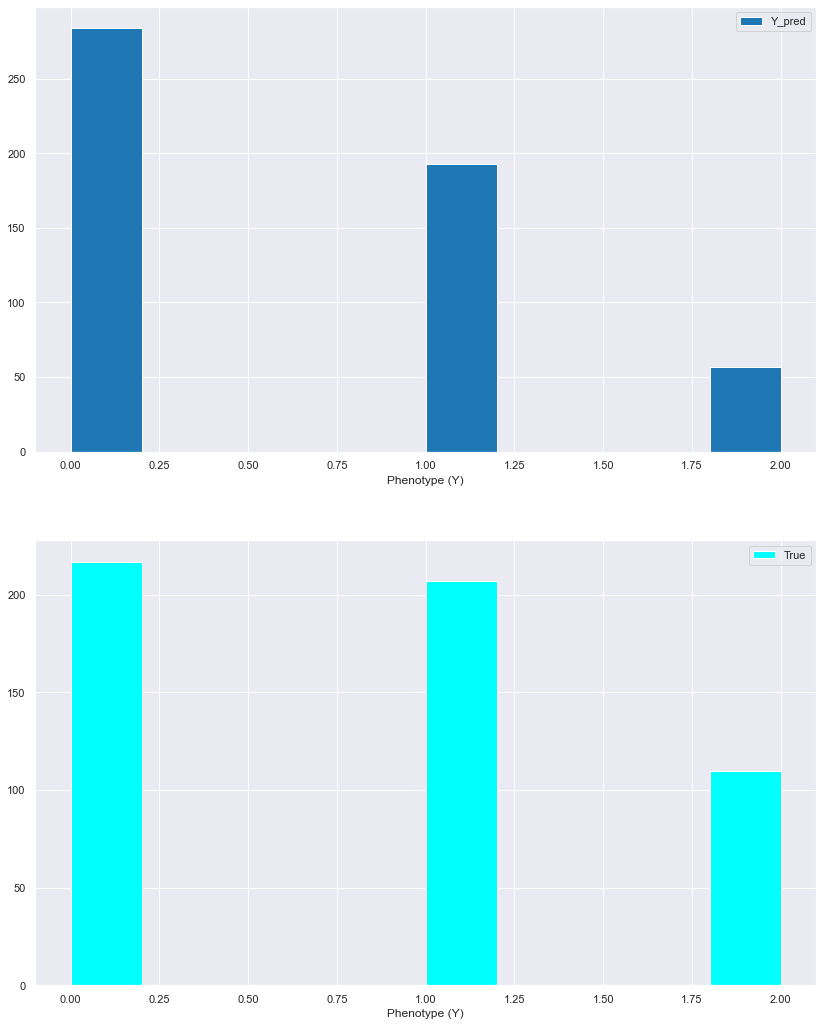

In [269]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def mlmodel(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X.astype(float), Y, test_size=0.3, random_state=7)
    model = SGDClassifier(loss='hinge')
    # model = RandomForestClassifier()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    kfold = KFold(n_splits=15)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    print(f"Accuracy: {cv_results.mean():.5f} ({cv_results.std():.5f})\n"
          + f"\nConfusion matrix:\n{confusion_matrix(Y_test, Y_pred)}\n"
          + f"\nClassification report:\n{classification_report(Y_test, Y_pred)}")
    
    fig, ax = plt.subplots(2, 1, figsize=(14, 2*9))
    ax[0].hist(Y_pred.astype(int), color='#1f77b4', label="Y_pred")
    ax[1].hist(Y_test.astype(int), color='cyan', label="True")
    
    for a in ax:
        a.set(xlabel="Phenotype (Y)")
        a.legend()
    plt.show()
    
mlmodel(X_dummy, Y)

## References & Further Reading:

- Jie Yuan1:26 PM https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- Jie Yuan1:30 PM https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
- McKelvey & Zavoina https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/